In [1]:
from src import get_azure_openai_model, get_azure_openai_chat_model, create_vector_store

model = get_azure_openai_chat_model()
vector_store = create_vector_store()

c:\Users\newac\OneDrive\Desktop\Master\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import pandas as pd
from langchain_core.documents import Document

xcl_file = pd.read_excel(r"eciu\ESCO Skills.xlsx")

df = pd.DataFrame(xcl_file)

df.rename(columns={'Name': 'esco_skill_name', 'Description': 'esco_description', 'URL': 'esco_url', 'URI': 'esco_uri'}, inplace=True)
df.reset_index(drop=True, inplace=True)

dict_list = df.to_dict(orient='records')

# Convert each dictionary in dict_list to a Document and add to vector_store
documents = [Document(page_content=str(d), metadata=d) for d in dict_list]
# documents[0]
vector_store.add_documents(documents=documents)

In [4]:
from langchain_community.document_loaders import Docx2txtLoader
import os

folder_path = r"eciu"
doc_files = [f for f in os.listdir(folder_path) if f.endswith('.docx')]
docx = []
for doc in doc_files:
    loaded_docs = Docx2txtLoader(os.path.join(folder_path, doc)).load()
    docx.extend(loaded_docs)
    vector_store.add_documents(documents=loaded_docs)



In [ ]:
import json
from pathlib import Path
from langchain_core.documents import Document
import os

def extract_information(data):
    # Extract the title, application deadline, and description
    title = data.get('Title', {}).get('En', 'N/A') if data.get('Title') else 'N/A'
    application_deadline = data.get('ApplicationDeadline', 'N/A')
    description = data.get('Description', {}).get('En', 'N/A') if data.get('Description') else 'N/A'

    # Extract CreditPoint
    credit_point = data.get('LearningAchievementSpecification', {}).get('CreditPoint', {}).get('Point', 'N/A') if data.get('LearningAchievementSpecification') and data['LearningAchievementSpecification'].get('CreditPoint') else 'N/A'

    # Extract Learning Outcomes
    learning_outcomes = []
    if data.get('LearningAchievementSpecification') and data['LearningAchievementSpecification'].get('LearningOutcome'):
        for outcome in data['LearningAchievementSpecification']['LearningOutcome']:
            outcome_title = outcome.get('Title', {}).get('En', 'N/A') if outcome.get('Title') else 'N/A'
            outcome_description = outcome.get('AdditionalNote', {}).get('NoteLiteral', {}).get('En', 'N/A') if outcome.get('AdditionalNote') and outcome['AdditionalNote'].get('NoteLiteral') else 'N/A'
            
            # Extract Related ESCO Skills
            related_skills = []
            if outcome.get('RelatedESCOSkill'):
                for skill in outcome['RelatedESCOSkill']:
                    skill_name = skill.get('PrefLabel', {}).get('En', 'N/A') if skill.get('PrefLabel') else 'N/A'
                    skill_url = skill.get('Id', 'N/A')
                    related_skills.append({
                        'esco_name': skill_name,
                        'esco_url': skill_url
                    })
            
            learning_outcomes.append({
                'title': outcome_title,
                'description': outcome_description,
                'related_skills': related_skills
            })
    
    # Return as a dictionary
    return {
        "title": title,
        "application_deadline": application_deadline,
        "description": description,
        "credit_point": credit_point,
        "learning_outcomes": learning_outcomes,
    }

# Directory containing JSON files
json_dir = r"eciu\json"
json_files = [os.path.join(json_dir, f) for f in os.listdir(json_dir) if f.endswith(".json")]

# List to hold documents
docs = []

# Process each JSON file
for json_file_path in json_files:
    parsed_data = json.loads(Path(json_file_path).read_text(encoding="utf-8"))
    info = extract_information(parsed_data)
    doc = Document(page_content=json.dumps(info), metadata={"source": json_file_path})
    docs.append(doc)

# Add documents to vector store
vector_store.add_documents(documents=docs)

In [6]:
# Retrival
retriever = vector_store.as_retriever(search_kwargs={"k": 20})

In [48]:
# Sample query to test the retriever
sample_query = "What are the skills required for circular economy?"

# Retrieve relevant documents
retrieved_docs = retriever.get_relevant_documents(sample_query)

# Print the retrieved documents
for doc in retrieved_docs:
    print(doc.page_content)

In [8]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
system = """You are an AI assistant designed to help users answer question. Answer only if you are confident that answer is in a given context. Always give the source of the answer. \n\n
        Only when user asks for travel information, you can provide information about travel from you general knowledge or accessing the web, provide information how do green travel if possible. \n\n"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Given the context: {document}, answer the question: {question}"),
    ]
)

retrieval_grader = qa_prompt |  model | StrOutputParser()



In [12]:
question = input("Enter your question: ")
docs = retriever.get_relevant_documents(question)

# Rerank the documents based on their relevance to the question
def reciprocal_rank_fusion(docs, question, k=60):
    # Example scoring function (you can use a more sophisticated method)
    def score(doc):
        return doc.page_content.lower().count(question.lower())

    # Rank documents based on the score
    ranked_docs = sorted(docs, key=score, reverse=True)
    
    # Apply Reciprocal Rank Fusion
    rr_scores = {}
    for rank, doc in enumerate(ranked_docs[:k]):
        doc_key = doc.page_content  # Use document content as the key
        rr_scores[doc_key] = rr_scores.get(doc_key, 0) + 1 / (rank + 1)
    
    # Sort documents based on RR scores
    fused_docs = sorted(ranked_docs[:k], key=lambda doc: rr_scores[doc.page_content], reverse=True)
    
    return fused_docs

# Rerank the documents based on their relevance to the question using Reciprocal Rank Fusion
reranked_docs = reciprocal_rank_fusion(docs, question)

# Get the top 5 documents
top_docs = reranked_docs[:5]


print(retrieval_grader.invoke({"question": question, "document": top_docs}))

The courses related to circular economy mentioned in the provided context are:

1. **Circular Sustainable Business Development**
   - Focuses on understanding the circular economy in relation to sustainability and business strategy.
   - Application Deadline: 2024-12-01
   - Credit Points: 5.0

2. **Circular Economy for Sustainability**
   - Provides advanced knowledge and critical understanding of circular economy principles and enablers.
   - Application Deadline: 2025-02-23
   - Credit Points: 2.0

3. **Business Modelling in the Circular Economy**
   - Covers foundations of business models and sustainability, with practical exercises on circular business models.
   - Application Deadline: 2025-01-30
   - Credit Points: 2.0

4. **Circular Economy for Office Furniture**
   - Examines the transition of the office furniture sector towards a circular economy, focusing on financial aspects and business cases.
   - Application Deadline: 2024-10-16
   - Credit Points: 3.0

These courses aim

In [51]:
top_docs

In [46]:
docs

In [10]:
question = input("Enter your question: ")
docs = retriever.get_relevant_documents(question)

# Rerank the documents based on their relevance to the question
def reciprocal_rank_fusion(docs, question, k=60):
    # Example scoring function (you can use a more sophisticated method)
    def score(doc):
        return doc.page_content.lower().count(question.lower())

    # Rank documents based on the score
    ranked_docs = sorted(docs, key=score, reverse=True)
    
    # Apply Reciprocal Rank Fusion
    rr_scores = {}
    for rank, doc in enumerate(ranked_docs[:k]):
        doc_key = doc.page_content  # Use document content as the key
        rr_scores[doc_key] = rr_scores.get(doc_key, 0) + 1 / (rank + 1)
    
    # Sort documents based on RR scores
    fused_docs = sorted(ranked_docs[:k], key=lambda doc: rr_scores[doc.page_content], reverse=True)
    
    return fused_docs

# Rerank the documents based on their relevance to the question using Reciprocal Rank Fusion
reranked_docs = reciprocal_rank_fusion(docs, question)

# Get the top 5 documents
top_docs = reranked_docs[:5]


print(retrieval_grader.invoke({"question": question, "document": top_docs}))

To travel from Stavanger to Tampere University as a green traveler, consider the following options:

1. **Train and Bus**: You can take a train from Stavanger to Oslo, and then from Oslo, take a train to Gothenburg. From Gothenburg, you can take a train to Stockholm, and finally, take a train or bus to Tampere. This option minimizes carbon emissions compared to flying.

2. **Ferry and Train**: Another option is to take a ferry from Stavanger to Denmark or Sweden, and then continue your journey by train to Tampere. This can be a scenic and eco-friendly way to travel.

3. **Bicycle**: If you're up for an adventure, consider cycling part of the way. You can bike from Stavanger to a nearby city with train connections, then take the train to Tampere.

4. **Carpooling**: If you need to drive, consider carpooling with others to reduce the number of vehicles on the road.

Make sure to check the schedules and routes in advance to find the most efficient and eco-friendly options. 

For more deta

In [49]:
from typing import List, Optional
from langgraph.graph import END, StateGraph, START
from typing_extensions import TypedDict
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    greeting: str
    question: str #stores original question as well as user generated questions and answers
    answer: str
    user_info: str
    documents: List[str]
    interview_questions: List[str]
    interview_answers: List[str]
    interciew_status: str
    

In [72]:
### Nodes
def greeting_node(state):
    greeting_message = """
    Hello! 👋 I'm the ECIU Coach, your guide to exploring exciting learning opportunities. 
    I'll help you navigate our engaging challenges and diverse micro-modules. 
    Feel free to ask me anything about ECIU!
    """
    print(greeting_message)
    question = state["question"]
    print(question)
    return {"greeting": greeting_message}


    






def retrieve_documents(state: GraphState):
    """Retrieves relevant documents."""
    print("------Retrieve documents------")
    print(state["question"])
    ret_docs = retriever.get_relevant_documents(state["question"])
    return {"documents": ret_docs}



def rerank_documents(state: GraphState):
    """Reranks the documents based on the question."""
    def reciprocal_rank_fusion(docs, question, k=20):
        # Example scoring function (you can use a more sophisticated method)
        def score(doc):
            return doc.page_content.lower().count(question.lower())

        # Rank documents based on the score
        ranked_docs = sorted(docs, key=score, reverse=True)
        
        # Apply Reciprocal Rank Fusion
        rr_scores = {}
        for rank, doc in enumerate(ranked_docs[:k]):
            doc_key = doc.page_content  # Use document content as the key
            rr_scores[doc_key] = rr_scores.get(doc_key, 0) + 1 / (rank + 1)
        
        # Sort documents based on RR scores
        fused_docs = sorted(ranked_docs[:k], key=lambda doc: rr_scores[doc.page_content], reverse=True)
        
        return fused_docs

    # Rerank the documents based on their relevance to the question using Reciprocal Rank Fusion
    reranked_docs = reciprocal_rank_fusion(state["documents"], state["question"])

    print(f"Top 5 documents:\n\n{reranked_docs[:5]}")


    return {"documents": reranked_docs[:5]}

# Interviewer
def interview(state):
    """Interviews the user and stores questions and answers in state."""

    user_info = state.get("user_info", "No prior user information available.")
    
    # Retrieve previous state
    questions = state.get("interview_questions", [])
    answers = state.get("interview_answers", [])

    # If there are no questions, generate them
    if not questions:
            system = """ *Improved Prompt (Enforcing Exact ESCO Skill Retrieval)* 
                "You are tasked with interviewing a user in the context of ECIU online university. Probably some data is already available about the user {user_info}.
                Based on the question asked, you must conduct a semi-structured interview, using the ESCO standard skills framework as the basis for structuring the conversation. 
                Ask the user about their *education, personal interests, hobbies, and inclinations, using 5 open-ended questions* to uncover relevant ESCO skills. 
                Ask one question at a time, wait for an answer, and then try to delve deeper to find *matching skills from the ESCO standard*. 
                Once all 5 questions are completed, *retrieve the top 10 ESCO skills that match the user from the ESCO skills dataset* and display them. 
    
                *The skill names must match exactly as they appear in the provided ESCO file. Do not generate or rephrase skills—only retrieve them as they are written.* 
                Each skill must include:
                - *Exact name* (as in ESCO)
                - *Definition*
                - *ESCO URI*
    
                **Task:** Generate exactly **2 interview questions** to understand the user’s background, education, and skills.
        
                **Question Format:**
                Q1: [First question]
                Q2: [Second question]
    
                """
    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Known user details: {user_info}"),
        ]
    )

    retrieval = qa_prompt | model | StrOutputParser()
    generated_questions = retrieval.invoke({"user_info": user_info}).split("\n")

    # Store generated questions in state
    state["interview_questions"] = generated_questions
    # state["interview_answers"] = []  # Initialize empty answer list

    print(f"Generated questions: {state['interview_questions']}")

    return {"interview_questions": generated_questions}

def asnwer_interview(state):
    """Answers the interview questions."""
    # Retrieve previous state
    questions = state.get("interview_questions", [])
    answers = state.get("interview_answers", [])

    # If there are no questions, generate them
    if not questions:
        return {"interview_status": "No questions to answer."}

    # Answer the questions
    for question in questions:
        # TO-DO: If the user doesn't want to answer, skip the question.
        print(f"Question: {question}")
        answer = input("Answer: ")
        answers.append(answer)

    print(f"Answers: {answers}")

    return {"interview_answers": answers}

def create_context(state):
    """Creates a context from the user's answers."""
    # Retrieve previous state
    questions = state.get("interview_questions", [])
    answers = state.get("interview_answers", [])


    if not answers:
        return {"user_info": "No answers available."}

    context = {q: a for q, a in zip(questions, answers)}
    state["user_info"] = context

    print(f"User info: {state['user_info']}")

    return {"user_info": context}

# def interview(state):
#     """Interviews the user."""
    # system = """ *Improved Prompt (Enforcing Exact ESCO Skill Retrieval)* 
    # "You are tasked with interviewing a user in the context of ECIU online university. Probably some data is already available about the user {user_info}.
    # Based on the {question} asked, you must conduct a semi-structured interview, using the ESCO standard skills framework as the basis for structuring the conversation. 
    # Ask the user about their *education, personal interests, hobbies, and inclinations, using 5 open-ended questions* to uncover relevant ESCO skills. 
    # Ask one question at a time, wait for an answer, and then try to delve deeper to find *matching skills from the ESCO standard*. 
    # Once all 5 questions are completed, *retrieve the top 10 ESCO skills that match the user from the ESCO skills dataset* and display them. 

    # *The skill names must match exactly as they appear in the provided ESCO file. Do not generate or rephrase skills—only retrieve them as they are written.* 
    # Each skill must include:
    # - *Exact name* (as in ESCO)
    # - *Definition*
    # - *ESCO URI*

    # GENERATE THE INTERVIEW QUESTIONS AND ANSWERS IN THE FOLLOWING FORMAT:
    # {
    # Q1: What is a task you frequently do in your studies or job?
    # Q2: What is your study background?
    # }

    # WHEN ALL YOUR QUESTIONS ARE ANSWERED OR YOU ARE SATISFIED WITH THE ANSWER, REPLY WITH 'DONE'. IF NOT, REPLY WITH 'NEXT QUESTION'.

    # 🚨 Example Output (Hypothetical Scenario):

    # #### User Interview Excerpt:
    # - Q1: What is a task you frequently do in your studies or job?
    #   A1: I often need to compare different options and decide on the best one.

    # ... (interview goes on) ...

    # Upon completion of the questions, provide matched skills:

    # - Matched ESCO Skill: **make decisions** – Make a choice from several alternative possibilities. 
    #   [ESCO URI](https://esco.ec.europa.eu/en/classification/skill?uri=http://data.europa.eu/esco/skill/d62d2b4c-a6f8-439e-8a1b-4f29ab5f2c47)

    # #### Final Output Structure:
    # 1. **make decisions** – Make a choice from several alternative possibilities.  
    #    [ESCO URI](https://esco.ec.europa.eu/en/classification/skill?uri=http://data.europa.eu/esco/skill/d62d2b4c-a6f8-439e-8a1b-4f29ab5f2c47)
    # 2. (next skill…)
    # """

#     print("------Interview------")

#     # Ensure 'user_info' exists, otherwise set a default empty value
#     user_info = state.get("user_info", "No prior user information available.")

#     qa_prompt = ChatPromptTemplate.from_messages(
#         [
#             ("system", system),
#             ("human", f"Ask user a question. Known user details: {user_info}"),
#         ]
#     )

#     interview = qa_prompt | model | StrOutputParser()
#     print("Interview started...")

#     # Pass user_info safely
#     interview_ans = interview.invoke({"user_info": user_info})

#     # TO-DO: Add logic to handle the interview answers into memory

#     print(f"Interview answer:{interview_ans}")
    
#     if interview_ans == "DONE":
#         print("Interview is done")
#         return {"interview_ans": "DONE"}
#     else:
#         print("Next question")
#         return {"interview_ans": interview_ans}

#     # return {"interview_ans": interview_ans}

def llm_answer(state):
    """Gets an answer from the LLM."""

    system = """You are an AI assistant designed to help users answer question. Answer only if you are confident that answer is in a given context. Always give the source of the answer. \n\n
        Only when user asks questions about travel/mobility, YOU CAN PROVIDE INFORMATION/HOW-TO ABOUT TRAVEL FROM YOU GENERAL KNOWLEDGE OR ACCESSING THE WEB, PROTIRIZE PROVIDING INFORMATION ABOUT GREEN TRAVEL . \n\n
        If you are give info on ESCO skills, provide the exact name, definition and ESCO URI. \n\n"""

    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Given the context: {document}, answer the question: {question}"),
        ]
    )
    print("------LLM answer------")
    print(state["question"])
    print(state["documents"])
    retrieval = qa_prompt |  model | StrOutputParser()
    llm_ans = retrieval.invoke({"question": state["question"], "document": state["documents"]})
    return {"answer": llm_ans}



In [73]:
### Edges
def judge_node(state):
    """Gets a user question. Based on what user asks, see if you have to interview the user for further information or pass on to the final llm."""

    question = state["question"]

    print("------Judge------")


    # system_prompt = """Determine whether answering the user's question requires additional information.
    # If the user is asking about skill improvement and the available information is insufficient, request an interview.
    # Otherwise, proceed with answering the question.
    # Respond with either 'INTERVIEW' or 'NOT-INTERVIEW'. """

    system = """You are an LLM Judge to determine whether answering the user's question requires additional information to answer or not based on the context.
    If the user is asking about skill improvement and the available information is insufficient, request an interview.
    INTERVIEW ONLY  when user is asking about GAINING NEW SKILLS or IMPROVING EXISTING SKILLS NOT WHEN TALKING ABOUT MOBILITY/TRANSPORT OR COURSES.
    Output: 'INTERVIEW' or 'NOT-INTERVIEW'."""

    
    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Enter your question:{question}"),
        ]
    )
    retrieval = qa_prompt |  model | StrOutputParser()
    print(f"{question}")
    print("ready to rule:")
    decision = retrieval.invoke({"question": question})
    print(decision)
    print("----Decision----")
    if decision == "INTERVIEW":
        return "interview"
    else:
        return "call_llm"

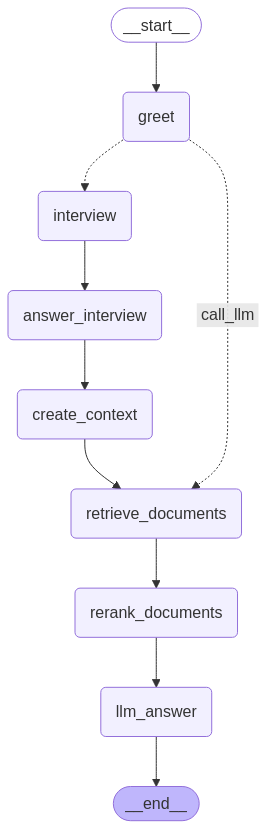

In [74]:
# Build the graph
graph = StateGraph(GraphState)
graph.add_node("greet", greeting_node)
# graph.add_node("judge_node", judge_node)
graph.add_node("answer_interview", asnwer_interview)
graph.add_node("create_context", create_context)
graph.add_node("retrieve_documents", retrieve_documents)
graph.add_node("rerank_documents", rerank_documents)
graph.add_node("llm_answer", llm_answer)
graph.add_node("interview", interview)

graph.add_edge(START, "greet")
graph.add_conditional_edges("greet", judge_node, {"interview": "interview", "call_llm": "retrieve_documents"})
graph.add_edge("interview", "answer_interview")
graph.add_edge("answer_interview", "create_context")
graph.add_edge("create_context", "retrieve_documents")

# graph.add_edge("retrieve_documents", "retrieve_documents")
graph.add_edge("retrieve_documents", "rerank_documents")
graph.add_edge("rerank_documents", "llm_answer")
graph.add_edge("llm_answer", END)

# Compile the graph
graph_runnable = graph.compile()

from IPython.display import Image, display

try:
    display(Image(graph_runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [77]:
# Run the graph
initial_state = {"question": "I want to gain skills in circular economy"}
# initial_state = {"greeting": "greeting"}
# input_data = {"user_info": ""}  # Add appropriate input data here
final_state = graph_runnable.invoke(initial_state)

# print(final_state)

# Print results
print("Generated Answer:", final_state["answer"])
print("Retrieved Documents:", final_state["documents"])
print("Original Question:", final_state["question"])
# print("Document Scores:", final_state["scores"])


    Hello! 👋 I'm the ECIU Coach, your guide to exploring exciting learning opportunities. 
    I'll help you navigate our engaging challenges and diverse micro-modules. 
    Feel free to ask me anything about ECIU!
    
I want to gain skills in circular economy
------Judge------
I want to gain skills in circular economy
ready to rule:
INTERVIEW
----Decision----
Generated questions: ['Q1: Can you tell me about your educational background and any specific subjects or fields of study that you are particularly passionate about?  ', 'Q2: What are some of your personal interests or hobbies that you engage in during your free time, and how do you think they contribute to your skills or knowledge?']
Question: Q1: Can you tell me about your educational background and any specific subjects or fields of study that you are particularly passionate about?  
Question: Q2: What are some of your personal interests or hobbies that you engage in during your free time, and how do you think they contribut

In [78]:
# Run the graph
initial_state = {"question": "what is ECIU?"}
# initial_state = {"greeting": "greeting"}
# input_data = {"user_info": ""}  # Add appropriate input data here
final_state = graph_runnable.invoke(initial_state)

# print(final_state)

# Print results
print("Generated Answer:", final_state["answer"])
print("Retrieved Documents:", final_state["documents"])
print("Original Question:", final_state["question"])
# print("Document Scores:", final_state["scores"])


    Hello! 👋 I'm the ECIU Coach, your guide to exploring exciting learning opportunities. 
    I'll help you navigate our engaging challenges and diverse micro-modules. 
    Feel free to ask me anything about ECIU!
    
what is ECIU?
------Judge------
what is ECIU?
ready to rule:
NOT-INTERVIEW
----Decision----
------Retrieve documents------
what is ECIU?
Top 5 documents:

[Document(id='4726e08e-a20a-4bac-8b8d-d333e4770e5e', metadata={'source': 'eciu\\Learning_Opportunity_Rehabilitation_and_Augmentation.docx'}, page_content='Learning Opportunity: Rehabilitation and Assistive Augmentation\n\nCourse Description\n\nIn this module, we will look at different technologies for physical and motor rehabilitation.\n\nLearning Outcomes and ESCO Skills\n\nUnderstanding of disabilities and abilities\n\nThe student will develop a nuanced understanding of disabilities and abilities.\n\nRelated ESCO Skills:\n\n- demonstrate consideration\n\n  ESCO Skill URL: http://data.europa.eu/esco/skill/9d75743b-3

In [ ]:
# Build the graph
graph = StateGraph(GraphState)
# graph.add_node(START, "retrieve")
# graph.add_node("retrieve", retrieve)
# graph.add_node("generate", generate)
# graph.add_node("grade_documents", grade_documents)

# # # Add edges (transitions)
# graph.add_edge(START, "retrieve")
# # graph.add_edge("retrieve", "generate")
# graph.add_edge("retrieve", "grade_documents")
# graph.add_conditional_edges("grade_documents", decide_generation, "generate")
# graph.add_edge("generate", END)


# Compile the graph
graph_runnable = graph.compile()

from IPython.display import Image, display

try:
    display(Image(graph_runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass




